/home/bkim/.cache/pypoetry/virtualenvs/tcc-mba-OcssbDWM-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



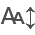

In [1]:
from hashlib import md5
from pathlib import Path
import re
from textwrap import dedent

from google.cloud.storage import transfer_manager
from itables import init_notebook_mode
import itables.options as opt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import add_constant
from tqdm.auto import tqdm

from pyenem.cache import Cache, normalize_formula
from pyenem.client import Client as EnemClient


init_notebook_mode(all_interactive=False)  # Set this to True to better explore tables
opt.maxBytes = 2 ** 17  # 128 KiB

In [2]:
enem = EnemClient(
    cache_dir='enem-2022-agg-cache',
    gcp_project='enem-microdata',
    bucket_name='enem-microdata',
    bucket_path='enem-2022-agg',
)

In [3]:
enem.query("SELECT COUNT(*) FROM `enem-microdata.enem_raw.enem_raw_2022`")

Read from cache d230297e


,f0_
0,3476105


In [4]:
enem.query("SELECT RAND()", use_cache=False)

Create cache for 2b2b00cc
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,f0_
0,0.502947


# Query builder

In [5]:
def ANSWERS(sg_area, area_offset, tp_lingua=-1, sequence_start=1, sequence_end=45):
    return dedent(
        f"""\
        SELECT
          NU_INSCRICAO,
          "{sg_area}" AS sg_area,
          {tp_lingua} AS tp_lingua,
          CO_PROVA_{sg_area} AS co_prova,
          NU_NOTA_{sg_area} AS nu_nota,
          i + {area_offset} AS co_posicao,
          i AS co_sequence,
          tp_faixa_etaria,
          tp_sexo,
          tp_escola,
          q001 AS educacao_pai,
          q002 AS educacao_mae,
          q005 AS num_pessoas_residencia,
          q006 as renda_familia,
          q022 as tem_celular_em_casa,
          q024 as tem_computador_em_casa,
          q025 as tem_internet_em_casa,
          SUBSTR(TX_RESPOSTAS_{sg_area}, i, 1) AS tx_resposta
        FROM
          enem_raw_2022,
          UNNEST(GENERATE_ARRAY({sequence_start}, {sequence_end})) i
        """
    )

print(ANSWERS("MT", 135))

SELECT
  NU_INSCRICAO,
  "MT" AS sg_area,
  -1 AS tp_lingua,
  CO_PROVA_MT AS co_prova,
  NU_NOTA_MT AS nu_nota,
  i + 135 AS co_posicao,
  i AS co_sequence,
  tp_faixa_etaria,
  tp_sexo,
  tp_escola,
  q001 AS educacao_pai,
  q002 AS educacao_mae,
  q005 AS num_pessoas_residencia,
  q006 as renda_familia,
  q022 as tem_celular_em_casa,
  q024 as tem_computador_em_casa,
  q025 as tem_internet_em_casa,
  SUBSTR(TX_RESPOSTAS_MT, i, 1) AS tx_resposta
FROM
  enem_raw_2022,
  UNNEST(GENERATE_ARRAY(1, 45)) i



In [6]:
def indent(num, text):
    return text.replace("\n", "\n" + "  " * num)

GROUP_BY = {
    'sg_area': 'sg_area',
    'tp_faixa_etaria': 'tp_faixa_etaria',
    'tp_sexo': 'tp_sexo',
    'tp_escola': indent(4, '''case
        when tp_escola = 1 then 'NA'
        when tp_escola = 2 then 'publica'
        when tp_escola = 3 then 'privada'
      end as tp_escola'''),
    'lingua_item': indent(4, '''case
        when tp_lingua = -1 then 'NA'
        when tp_lingua = 0 then 'ingles'
        when tp_lingua = 1 then 'espanhol'
      end as lingua_item'''),
    'educacao_pai': 'educacao_pai',
    'educacao_mae': 'educacao_mae',
    'num_pessoas_residencia': 'num_pessoas_residencia',
    'renda_familia': 'renda_familia',
    'tem_celular_em_casa': 'tem_celular_em_casa',
    'tem_computador_em_casa': 'tem_computador_em_casa',
    'tem_internet_em_casa': 'tem_internet_em_casa',
}


def QUERY(
        sampling=1.0 / 16,
        co_items=(),
        group_by=GROUP_BY,
        append_sql="SELECT * FROM acertos",
):
    out_of_256 = sampling * 256
    item_filter = 'TRUE'
    if co_items:
        item_list = ', '.join(map(str, co_items))
        item_filter = f'co_item IN ({item_list})'

    def group_field(field):
        if field in group_by:
            return group_by[field]
        return f'NULL AS {field}'
    
    return dedent(
        f"""\
        WITH
        enem_raw_2022 AS (
            SELECT *
            FROM `enem-microdata.enem_raw.enem_raw_2022`
            WHERE
              TP_PRESENCA_LC = 1
              AND TP_PRESENCA_MT = 1
              AND NU_NOTA_LC > 0
              AND NU_NOTA_CH > 0
              AND NU_NOTA_CN > 0
              AND NU_NOTA_MT > 0
              -- Sample records
              AND to_code_points(md5(cast(nu_inscricao as string)))[offset(0)] < {out_of_256}
        ),
        items_2022 AS (
            SELECT
              * REPLACE (IFNULL(TP_LINGUA, -1) AS TP_LINGUA)
            FROM `enem-microdata.items.2022`
            WHERE in_item_aban = 0 AND {item_filter}
        ),
        answers_lc_language AS (
            {indent(6, ANSWERS("LC", 0, "tp_lingua", 1, 5))}
        ),
        answers_lc_not_language AS (
            {indent(6, ANSWERS("LC", 0, -1, 6, 45))}
        ),
        answers_ch AS (
            {indent(6, ANSWERS("CH", 45))}
        ),
        answers_cn AS (
            {indent(6, ANSWERS("CN", 90))}
        ),
        answers_mt AS (
            {indent(6, ANSWERS("MT", 135))}
        ),
        answers AS (
            SELECT * FROM answers_lc_language
            UNION ALL
            SELECT * FROM answers_lc_not_language
            UNION ALL
            SELECT * FROM answers_ch
            UNION ALL
            SELECT * FROM answers_cn
            UNION ALL
            SELECT * FROM answers_mt
        ),
        item_answer AS (
            SELECT *
            FROM answers
            INNER JOIN items_2022 USING (sg_area, tp_lingua, co_prova, co_posicao)
        ),
        acertos AS (
            SELECT
              co_item,
              co_posicao,
              co_sequence,
              {group_field('sg_area')},
              {group_field('tp_faixa_etaria')},
              {group_field('tp_sexo')},
              {group_field('tp_escola')},
              {group_field('lingua_item')},
              {group_field('educacao_pai')},
              {group_field('educacao_mae')},
              {group_field('num_pessoas_residencia')},
              {group_field('renda_familia')},
              {group_field('tem_celular_em_casa')},
              {group_field('tem_computador_em_casa')},
              {group_field('tem_internet_em_casa')},
              0.1*(ceil(nu_param_a/0.1)) AS a_range,
              0.1*(ceil(nu_param_b/0.1)) AS b_range,
              0.01*(ceil(nu_param_c/0.01)) AS c_range,
              10*(ceil(nu_nota/10)) AS nota_range,
              sum(if(tx_resposta = tx_gabarito, 1, 0)) AS acerto_sum,
              sum(if(tx_resposta != tx_gabarito, 1, 0)) AS erro_sum,
            FROM item_answer
            GROUP BY
              co_item,
              co_posicao,
              co_sequence,
              sg_area,
              tp_faixa_etaria,
              tp_sexo,
              tp_escola,
              lingua_item,
              educacao_pai,
              educacao_mae,
              num_pessoas_residencia,
              renda_familia,
              tem_celular_em_casa,
              tem_computador_em_casa,
              tem_internet_em_casa,
              a_range,
              b_range,
              c_range,
              nota_range
        )
        {append_sql};
        """
    )

print(QUERY(0.01))

WITH
enem_raw_2022 AS (
    SELECT *
    FROM `enem-microdata.enem_raw.enem_raw_2022`
    WHERE
      TP_PRESENCA_LC = 1
      AND TP_PRESENCA_MT = 1
      AND NU_NOTA_LC > 0
      AND NU_NOTA_CH > 0
      AND NU_NOTA_CN > 0
      AND NU_NOTA_MT > 0
      -- Sample records
      AND to_code_points(md5(cast(nu_inscricao as string)))[offset(0)] < 2.56
),
items_2022 AS (
    SELECT
      * REPLACE (IFNULL(TP_LINGUA, -1) AS TP_LINGUA)
    FROM `enem-microdata.items.2022`
    WHERE in_item_aban = 0 AND TRUE
),
answers_lc_language AS (
    SELECT
      NU_INSCRICAO,
      "LC" AS sg_area,
      tp_lingua AS tp_lingua,
      CO_PROVA_LC AS co_prova,
      NU_NOTA_LC AS nu_nota,
      i + 0 AS co_posicao,
      i AS co_sequence,
      tp_faixa_etaria,
      tp_sexo,
      tp_escola,
      q001 AS educacao_pai,
      q002 AS educacao_mae,
      q005 AS num_pessoas_residencia,
      q006 as renda_familia,
      q022 as tem_celular_em_casa,
      q024 as tem_computador_em_casa,
      q025 as tem_

# Filtering items

In [7]:
items = enem.query("""
    WITH
    enem_raw_2022 AS (
        SELECT *
        FROM `enem-microdata.enem_raw.enem_raw_2022`
        WHERE
          TP_PRESENCA_LC = 1
          AND TP_PRESENCA_MT = 1
          AND NU_NOTA_LC > 0
          AND NU_NOTA_CH > 0
          AND NU_NOTA_CN > 0
          AND NU_NOTA_MT > 0
    ),
    items_2022 AS (
        SELECT *
        FROM `enem-microdata.items.2022`
        WHERE in_item_aban = 0
    ),
    provas AS (
        SELECT CO_PROVA_LC AS co_prova FROM enem_raw_2022
        UNION ALL
        SELECT CO_PROVA_CH AS co_prova FROM enem_raw_2022
        UNION ALL
        SELECT CO_PROVA_CN AS co_prova FROM enem_raw_2022
        UNION ALL
        SELECT CO_PROVA_MT AS co_prova FROM enem_raw_2022
    ),
    num_prova AS (
        SELECT co_prova, COUNT(*) AS cnt
        FROM provas
        GROUP BY 1
    ),
    num_itens AS (
        SELECT co_prova, cnt, co_posicao, sg_area, co_item, tp_lingua, nu_param_a, nu_param_b, nu_param_c
        FROM num_prova a
        LEFT JOIN items_2022 b USING (co_prova)
    )
    SELECT * FROM num_itens
""")

Read from cache a64adad0


In [8]:
items

,co_prova,cnt,co_posicao,sg_area,co_item,tp_lingua,nu_param_a,nu_param_b,nu_param_c
0,1155,510,165,MT,67147,<NA>,1.45002,0.98124,0.20846
1,1155,510,161,MT,63318,<NA>,1.62143,1.56727,0.15547
2,1155,510,155,MT,63862,<NA>,1.25949,2.10425,0.26204
3,1155,510,139,MT,43039,<NA>,1.29609,2.26288,0.10236
4,1155,510,146,MT,31366,<NA>,2.21676,1.74238,0.20214
...,...,...,...,...,...,...,...,...,...
2515,1179,7305,12,LC,42674,<NA>,2.26956,0.51892,0.23370
2516,1179,7305,10,LC,49544,<NA>,2.43974,1.15872,0.12513
2517,1179,7305,11,LC,41810,<NA>,0.92958,0.15096,0.01173
2518,1179,7305,13,LC,120622,<NA>,2.55800,0.65099,0.12178


In [9]:
co_items = (
    items
    .groupby(['co_item', 'co_prova'])
    .filter(lambda x: x.sum().cnt >= 10000)
    .co_item
    .unique()
)
co_items = sorted(co_items)

In [10]:
len(co_items)

178

# Tools

In [11]:
def build_coef_df(result):
    coef_df = (
        pd.concat([result.params, result.pvalues, result.bse], axis=1)
        .rename(columns={0:'coef', 1:'pvalue', 2:'stderr'})
    )
    coef_df = coef_df.drop(['const', 'Intercept'], errors='ignore')  # Drop intercept param
    coef_df['low'] = coef_df.coef - 1.96*coef_df.stderr
    coef_df['high'] = coef_df.coef + 1.96*coef_df.stderr
    return coef_df

In [12]:
def coefplot(result, max_pvalue=0.05):
    coef_df = build_coef_df(result)
    significant = (
        coef_df[coef_df['pvalue'] <= max_pvalue]
        .sort_values('coef', key=lambda x:x.abs())
    )
    plt.errorbar(significant.coef, significant.index, xerr=1.96*significant.stderr, fmt='.')
    
    ax = plt.gcf().axes[0]
    ax.grid(True)
    for item in ax.get_yticklabels():
        item.set_fontsize(7)

    return coef_df

In [13]:
def prepare_dataset(df):
    df['weights'] = df.acerto_sum + df.erro_sum
    df['acerto_freq'] = df.acerto_sum / df.weights

    df = df.assign(
        co_posicao=df.co_posicao.astype("float64"),
        co_sequence=df.co_sequence.astype("float64"),
        acerto_sum=df.acerto_sum.astype("float64"),
        erro_sum=df.erro_sum.astype("float64"),
    )
    
    df['faixa_etaria'] = df.tp_faixa_etaria.map({
        1: 16.0,
        2: 17.0,
        3: 18.0,
        4: 19.0,
        5: 20.0,
        6: 21.0,
        7: 22.0,
        8: 23.0,
        9: 24.0,
        10: 25.0,
        11: 28.0,
        12: 33.0,
        13: 38.0,
        14: 43.0,
        15: 48.0,
        16: 53.0,
        17: 58.0,
        18: 63.0,
        19: 68.0,
        20: 73.0,
    })
    
    df['renda_familia'] = df.renda_familia.map({
        'A': 0,
        'B': 1212.0/2,
        'C': (1212.01+1818)/2,
        'D': (1818.01+2424)/2,
        'E': (2424.01+3030)/2,
        'F': (3030.01+3636)/2,
        'G': (3636.01+4848)/2,
        'H': (4848.01+6060)/2,
        'I': (6060.01+7272)/2,
        'J': (7272.01+8484)/2,
        'K': (8484.01+9696)/2,
        'L': (9696.01+10908)/2,
        'M': (10908.01+12120)/2,
        'N': (12120.01+14544)/2,
        'O': (14544.01+18180)/2,
        'P': (18180.01+24240)/2,
        'Q': 24240.01,
    })
    
    df['num_computadores'] = df.tem_computador_em_casa.map({
        'A': 0.0,
        'B': 1.0,
        'C': 2.0,
        'D': 3.0,
        'E': 4.0,
    })
    
    df['num_celulares'] = df.tem_celular_em_casa.map({
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3,
        'E': 4,
    })
    
    df['tem_internet_em_casa'] = df.tem_internet_em_casa.map({
        'A': 0,
        'B': 1,
    })
    
    df = df.drop(['tp_faixa_etaria', 'tem_computador_em_casa', 'tem_celular_em_casa'], axis=1)
    
    return df

# Exploration

In [14]:
enem.query(QUERY(sampling=1.0, append_sql="SELECT COUNT(*) FROM item_answer"))

Create cache for d90ce6f6
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,f0_
0,405164943


In [15]:
enem.query(QUERY(sampling=1.0, append_sql="SELECT COUNT(DISTINCT nu_inscricao) FROM item_answer"))

Create cache for 8182d1da
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,f0_
0,2341913


In [16]:
enem.query(QUERY(sampling=1.0, append_sql="SELECT COUNT(DISTINCT co_item) FROM item_answer"))

Create cache for 1c99faa8
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,f0_
0,372


In [17]:
enem.query(QUERY(sampling=1.0, append_sql="SELECT COUNT(*) FROM acertos"))

Create cache for bff55709
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,f0_
0,351273067


In [18]:
enem.query(QUERY(sampling=1.0, append_sql=f"""
SELECT COUNT(*)
FROM item_answer
WHERE co_item IN ({','.join(map(str, co_items))})"""))

Create cache for b9021227
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,f0_
0,404888546


In [19]:
enem.query(QUERY(sampling=1.0, append_sql=f"""
SELECT COUNT(DISTINCT nu_inscricao)
FROM item_answer
WHERE co_item IN ({','.join(map(str, co_items))})"""))

Create cache for 8748683b
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,f0_
0,2341169


In [20]:
enem.query(QUERY(sampling=1.0, append_sql=f"""
SELECT COUNT(*)
FROM acertos
WHERE co_item IN ({','.join(map(str, co_items))})"""))

Create cache for c76a1f85
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,f0_
0,350996715


In [21]:
enem.query(QUERY(sampling=1.0/256, append_sql=f"""
SELECT COUNT(*)
FROM acertos
WHERE co_item IN ({','.join(map(str, co_items))})"""))

Create cache for 5aa050a6
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,f0_
0,1590778


In [22]:
enem.query(QUERY(sampling=1.0/256, append_sql=f"""
SELECT COUNT(*)
FROM item_answer
WHERE co_item IN ({','.join(map(str, co_items))})"""))

Create cache for a84d5968
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,f0_
0,1592185


In [23]:
enem.query(QUERY(sampling=0.04, append_sql=f"""
SELECT COUNT(*)
FROM acertos
WHERE co_item IN ({','.join(map(str, co_items))})"""))

Create cache for 8b5105a5
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,f0_
0,17354255


In [24]:
enem.query(QUERY(sampling=0.04, append_sql=f"""
SELECT COUNT(*)
FROM item_answer
WHERE co_item IN ({','.join(map(str, co_items))})"""))

Create cache for 1aa2656d
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,f0_
0,17520976


In [25]:
df_simple = enem.query(
    QUERY(
        sampling=0.04,
        group_by={'nota_range': 'nota_range'},
        append_sql=f"""
            SELECT
                co_sequence,
                nota_range,
                (acerto_sum + erro_sum) as cnt,
                acerto_sum / (acerto_sum + erro_sum) AS acerto_freq
            FROM acertos
            WHERE co_item IN ({','.join(map(str, co_items))})
            """
    )
)

df_simple

Read from cache 4316c25d


,co_sequence,nota_range,cnt,acerto_freq
0,3,280.0,10,0.000000
1,18,890.0,30,0.700000
2,33,890.0,30,0.966667
3,19,880.0,43,0.488372
4,29,880.0,43,1.000000
...,...,...,...,...
36503,5,830.0,1,1.000000
36504,16,830.0,1,1.000000
36505,17,830.0,1,1.000000
36506,28,830.0,1,1.000000


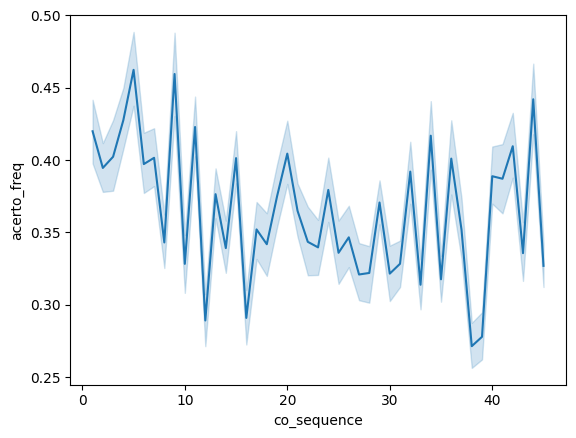

In [26]:
ax = sns.lineplot(df_simple, x='co_sequence', y='acerto_freq', weights='cnt')

In [27]:
model = smf.glm(
    "acerto_freq ~ co_sequence + nota_range", 
    data=df_simple, family=sm.families.Binomial(), freq_weights=df_simple.cnt
)
result = model.fit()
print('acerto_freq = 1/(1+exp(-z)); z = %.4f + %.4f * co_sequence + %.4f * nota_range' % (
    result.params.Intercept,
    result.params.co_sequence,
    result.params.nota_range,
))
result.summary()

acerto_freq = 1/(1+exp(-z)); z = -3.8667 + -0.0053 * co_sequence + 0.0064 * nota_range


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            acerto_freq   No. Observations:                36508
Model:                            GLM   Df Residuals:                 17520973
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.8693e+06
Date:                Wed, 17 Apr 2024   Deviance:                   3.2146e+06
Time:                        23:11:04   Pearson chi2:                 2.99e+06
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.8667      0.003  -1121.908      0.000      -3.873      -3.860
co_sequence    -0.0053   3.97e-05   -133.512      0.000      -0.005      -0.005
nota_range      0.0064   6.13e-06   1048.805      0.000       0.006       0.006
===============================================================================
"""

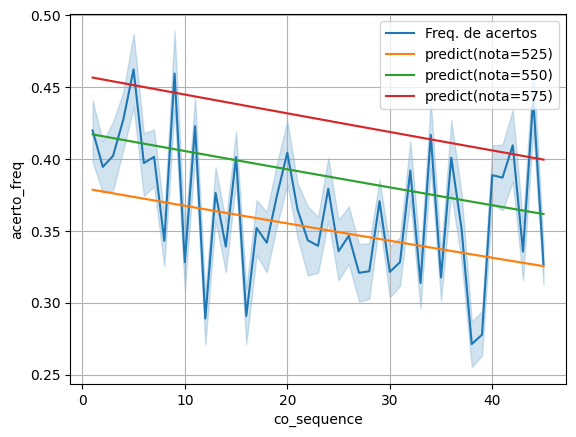

In [28]:
x = df_simple.co_sequence
beta, a1, a2 = result.params.Intercept, result.params.co_sequence, result.params.nota_range

def y(nota):
    z = beta + a1 * x + a2 * nota
    return 1/(1+np.exp(-z))

ax = sns.lineplot(df_simple, x='co_sequence', y='acerto_freq', weights='cnt', label='Freq. de acertos')
sns.lineplot(x=x, y=y(525), label='predict(nota=525)', ax=ax)
sns.lineplot(x=x, y=y(550), label='predict(nota=550)', ax=ax)
sns.lineplot(x=x, y=y(575), label='predict(nota=575)', ax=ax)
ax.grid(True)

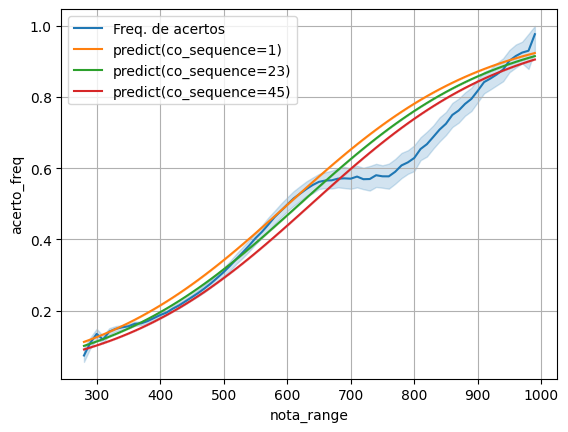

In [29]:
x = df_simple.nota_range
beta, a1, a2 = result.params.Intercept, result.params.co_sequence, result.params.nota_range

def y(posicao):
    z = beta + a1 * posicao + a2 * x
    return 1/(1+np.exp(-z))

ax = sns.lineplot(df_simple, x='nota_range', y='acerto_freq', weights='cnt', label='Freq. de acertos')
sns.lineplot(x=x, y=y(1), label='predict(co_sequence=1)', ax=ax)
sns.lineplot(x=x, y=y(23), label='predict(co_sequence=23)', ax=ax)
sns.lineplot(x=x, y=y(45), label='predict(co_sequence=45)', ax=ax)
ax.grid(True)

In [30]:
# Porcentagem de candidatos com nota maior que 806.25
enem.query("""
WITH
enem2022 AS (SELECT * FROM `enem-microdata.enem_raw.enem_raw_2022`),
a AS (SELECT COUNT(*) cnt FROM enem2022 WHERE nu_nota_mt > 0),
b AS (SELECT COUNT(*) cnt FROM enem2022 WHERE nu_nota_mt >= 806.25),
c AS (SELECT a.cnt as total, b.cnt as num, b.cnt / a.cnt as frac FROM a, b)
select * from c
""")

Read from cache 202dc3c7


,total,num,frac
0,2354852,50256,0.021341


# Single item 5961

In [31]:
sql = QUERY(sampling=1.0, co_items=(5961,))
df_5961 = enem.query(sql)

df_5961

Read from cache 20ee6a89


,co_item,co_posicao,co_sequence,sg_area,tp_faixa_etaria,tp_sexo,tp_escola,lingua_item,educacao_pai,educacao_mae,...,renda_familia,tem_celular_em_casa,tem_computador_em_casa,tem_internet_em_casa,a_range,b_range,c_range,nota_range,acerto_sum,erro_sum
0,5961,158,23,MT,1,M,NA,NA,F,G,...,H,D,D,B,1.0,2.5,0.17,750.0,0,1
1,5961,158,23,MT,4,M,NA,NA,F,H,...,C,D,A,B,1.0,2.5,0.17,390.0,0,1
2,5961,158,23,MT,2,F,publica,NA,G,E,...,B,C,A,B,1.0,2.5,0.17,490.0,1,0
3,5961,158,23,MT,3,F,publica,NA,H,H,...,C,C,A,B,1.0,2.5,0.17,380.0,1,0
4,5961,158,23,MT,4,F,NA,NA,B,D,...,B,C,B,B,1.0,2.5,0.17,530.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090107,5961,158,23,MT,4,M,publica,NA,D,B,...,B,B,A,B,1.0,2.5,0.17,480.0,0,1
2090108,5961,158,23,MT,2,F,privada,NA,E,E,...,G,D,A,B,1.0,2.5,0.17,340.0,0,1
2090109,5961,173,38,MT,3,M,privada,NA,F,F,...,P,E,C,B,1.0,2.5,0.17,770.0,1,0
2090110,5961,173,38,MT,2,F,publica,NA,D,E,...,D,B,A,B,1.0,2.5,0.17,410.0,0,1


In [32]:
df_5961 = prepare_dataset(df_5961)

formula = """
    acerto_freq ~
        co_sequence
        + faixa_etaria
        + tp_sexo
        + tp_escola
        + lingua_item
        + educacao_pai
        + educacao_mae
        + num_pessoas_residencia
        + renda_familia
        + num_celulares
        + num_computadores
        + tem_internet_em_casa
        + nota_range
"""
model = smf.glm(
    formula, data=df_5961, family=sm.families.Binomial(), freq_weights=df_5961.weights
)
result = model.fit()

In [33]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            acerto_freq   No. Observations:              2090112
Model:                            GLM   Df Residuals:                  2339473
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3274e+06
Date:                Wed, 17 Apr 2024   Deviance:                   2.4724e+06
Time:                        23:11:59   Pearson chi2:                 2.09e+06
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04875
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.7961      0.018   -156.078      0.000      -2.831      -2.761
tp_sexo[T.M]              -0.0080      0.003     -2.635      0.008      -0.014      -0.002
tp_escola[T.privada]      -0.0077      0.006     -1.404      0.160      -0.019       0.003
tp_escola[T.publica]       0.0344      0.003     10.015      0.000       0.028       0.041
educacao_pai[T.B]          0.0051      0.010      0.506      0.613      -0.015       0.025
educacao_pai[T.C]         -0.0075      0.010     -0.718      0.473      -0.028       0.013
educacao_pai[T.D]         -0.0059      0.011     -0.554      0.580      -0.027       0.015
educacao_pai[T.E]         -0.0083      0.010     -0.815      0.415      -0.028       0.012
educacao_pai[T.F]          0.0010      0.011      0.093      0.926      -0.021       0.023
educacao_pai[T.G]          0.0093      0.012      0.803      0.422      -0.013       0.032
educacao_pai[T.H]          0.0169      0.011      1.538      0.124      -0.005       0.038
educacao_mae[T.B]         -0.0192      0.013     -1.494      0.135      -0.044       0.006
educacao_mae[T.C]         -0.0146      0.013     -1.110      0.267      -0.040       0.011
educacao_mae[T.D]         -0.0081      0.013     -0.615      0.538      -0.034       0.018
educacao_mae[T.E]         -0.0100      0.013     -0.785      0.433      -0.035       0.015
educacao_mae[T.F]         -0.0115      0.013     -0.861      0.389      -0.038       0.015
educacao_mae[T.G]         -0.0067      0.013     -0.497      0.619      -0.033       0.020
educacao_mae[T.H]          0.0207      0.016      1.316      0.188      -0.010       0.052
co_sequence               -0.0077      0.000    -56.490      0.000      -0.008      -0.007
faixa_etaria              -0.0069      0.000    -24.021      0.000      -0.007      -0.006
num_pessoas_residencia     0.0154      0.001     12.593      0.000       0.013       0.018
renda_familia          -3.887e-06   4.35e-07     -8.934      0.000   -4.74e-06   -3.03e-06
num_celulares             -0.0030      0.002     -1.786      0.074      -0.006       0.000
num_computadores          -0.0026      0.002     -1.246      0.213      -0.007       0.002
tem_internet_em_casa      -0.0333      0.006     -5.529      0.000      -0.045      -0.021
nota_range                 0.0041   1.46e-05    278.486      0.000       0.004       0.004
==========================================================================================
"""

,coef,pvalue,stderr,low,high
tp_sexo[T.M],-0.008013,8.425516e-03,3.041575e-03,-0.013975,-0.002052
tp_escola[T.privada],-0.007746,1.601921e-01,5.515481e-03,-0.018556,0.003064
tp_escola[T.publica],0.034379,1.303398e-23,3.432635e-03,0.027651,0.041107
educacao_pai[T.B],0.005085,6.127626e-01,1.004731e-02,-0.014607,0.024778
educacao_pai[T.C],-0.007485,4.730544e-01,1.043143e-02,-0.027930,0.012961
educacao_pai[T.D],-0.005881,5.798333e-01,1.062192e-02,-0.026700,0.014938
educacao_pai[T.E],-0.008263,4.150321e-01,1.013750e-02,-0.028132,0.011607
educacao_pai[T.F],0.001029,9.255687e-01,1.101113e-02,-0.020553,0.022610
educacao_pai[T.G],0.009303,4.222121e-01,1.159142e-02,-0.013416,0.032022
educacao_pai[T.H],0.016854,1.241101e-01,1.096002e-02,-0.004628,0.038335


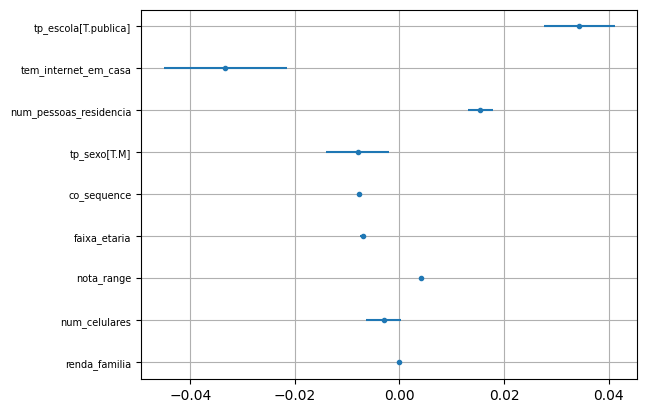

In [34]:
coefplot(result, 0.10)

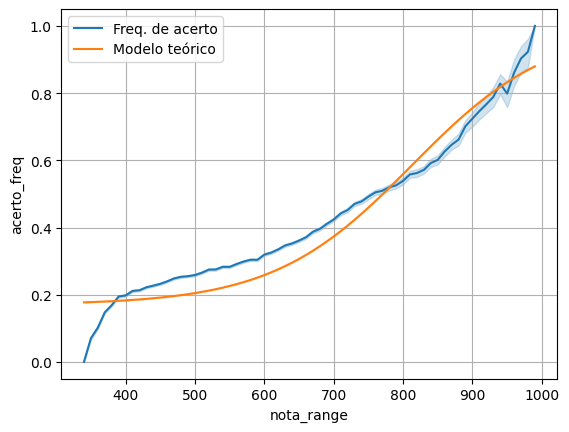

In [35]:
ax = sns.lineplot(df_5961, x='nota_range', y='acerto_freq', label='Freq. de acerto')

a, b, c = 1.0/100, 500+125*2.5, 0.17
x = df_5961.nota_range
y = c + (1-c)/(1 + np.exp(-a*(x - b)))
sns.lineplot(x=x, y=y, label='Modelo teórico')
ax.grid(True)

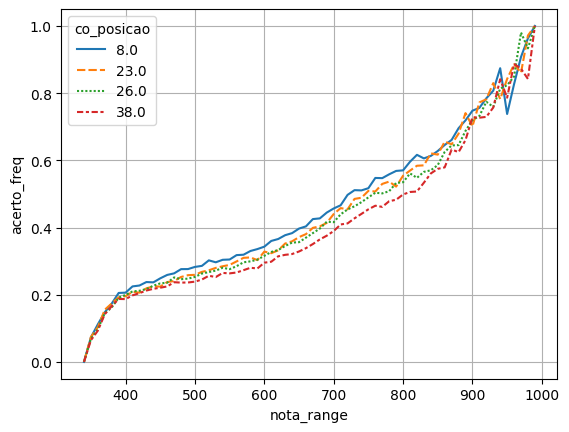

In [36]:
ax = sns.lineplot(
    df_5961, x='nota_range', y='acerto_freq',
    hue=df_5961.co_posicao-135, style=df_5961.co_posicao-135,
    errorbar=None, palette='tab10')
ax.grid(True)

# Initial analysis

In [58]:
sql = QUERY(sampling=1.0 / 256, co_items=co_items)
df = enem.query(sql, fetch_strategy='gcs')

df = prepare_dataset(df)

Read from cache 75f6ebe7


In [59]:
df.nunique()

co_item                   178
co_posicao                180
co_sequence                45
sg_area                     4
tp_sexo                     2
tp_escola                   3
lingua_item                 3
educacao_pai                8
educacao_mae                8
num_pessoas_residencia     17
renda_familia              17
tem_internet_em_casa        2
a_range                    44
b_range                    42
c_range                    31
nota_range                 70
acerto_sum                  3
erro_sum                    3
weights                     2
acerto_freq                 3
faixa_etaria               20
num_computadores            5
num_celulares               5
dtype: int64

In [60]:
df.dtypes

co_item                     int64
co_posicao                float64
co_sequence               float64
sg_area                    object
tp_sexo                    object
tp_escola                  object
lingua_item                object
educacao_pai               object
educacao_mae               object
num_pessoas_residencia      int64
renda_familia             float64
tem_internet_em_casa        int64
a_range                   float64
b_range                   float64
c_range                   float64
nota_range                float64
acerto_sum                float64
erro_sum                  float64
weights                     int64
acerto_freq               float64
faixa_etaria              float64
num_computadores          float64
num_celulares               int64
dtype: object

## Linear model

In [61]:
formula = normalize_formula(
    """
    acerto_freq ~
        co_sequence
        + sg_area
        + faixa_etaria
        + tp_sexo
        + tp_escola
        + lingua_item
        + educacao_pai
        + educacao_mae
        + num_pessoas_residencia
        + renda_familia
        + num_celulares
        + num_computadores
        + tem_internet_em_casa
        + a_range
        + b_range
        + c_range
        + nota_range
    """
)

model = smf.glm(
    formula, data=df, family=sm.families.Binomial(), freq_weights=df.weights
)
result = model.fit()

In [62]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            acerto_freq   No. Observations:              1590778
Model:                            GLM   Df Residuals:                  1592151
Model Family:                Binomial   Df Model:                           33
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.9960e+05
Date:                Wed, 17 Apr 2024   Deviance:                   1.7983e+06
Time:                        22:55:49   Pearson chi2:                 1.82e+06
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1670
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.2208      0.024   -136.531      0.000      -3.267      -3.175
sg_area[T.CN]              -0.0421      0.005     -7.766      0.000      -0.053      -0.031
sg_area[T.LC]              -0.0583      0.005    -11.474      0.000      -0.068      -0.048
sg_area[T.MT]               0.1138      0.006     19.327      0.000       0.102       0.125
tp_sexo[T.M]               -0.0094      0.004     -2.508      0.012      -0.017      -0.002
tp_escola[T.privada]       -0.0089      0.007     -1.308      0.191      -0.022       0.004
tp_escola[T.publica]       -0.0180      0.004     -4.204      0.000      -0.026      -0.010
lingua_item[T.espanhol]     0.0525      0.016      3.222      0.001       0.021       0.084
lingua_item[T.ingles]       0.4713      0.014     32.605      0.000       0.443       0.500
educacao_pai[T.B]           0.0043      0.012      0.365      0.715      -0.019       0.028
educacao_pai[T.C]           0.0034      0.012      0.275      0.783      -0.021       0.028
educacao_pai[T.D]          -0.0005      0.013     -0.037      0.971      -0.025       0.024
educacao_pai[T.E]           0.0005      0.012      0.045      0.964      -0.023       0.024
educacao_pai[T.F]           0.0173      0.013      1.305      0.192      -0.009       0.043
educacao_pai[T.G]           0.0068      0.014      0.487      0.626      -0.020       0.034
educacao_pai[T.H]          -0.0066      0.013     -0.505      0.613      -0.032       0.019
educacao_mae[T.B]          -0.0031      0.015     -0.208      0.835      -0.032       0.026
educacao_mae[T.C]          -0.0003      0.015     -0.022      0.983      -0.031       0.030
educacao_mae[T.D]           0.0069      0.015      0.445      0.657      -0.023       0.037
educacao_mae[T.E]           0.0066      0.015      0.439      0.660      -0.023       0.036
educacao_mae[T.F]           0.0099      0.016      0.631      0.528      -0.021       0.041
educacao_mae[T.G]           0.0152      0.016      0.954      0.340      -0.016       0.046
educacao_mae[T.H]           0.0047      0.019      0.251      0.802      -0.032       0.042
co_sequence                -0.0039      0.000    -26.873      0.000      -0.004      -0.004
faixa_etaria                0.0019      0.000      5.432      0.000       0.001       0.003
num_pessoas_residencia     -0.0015      0.001     -0.989      0.323      -0.004       0.001
renda_familia            2.244e-06    5.4e-07      4.159      0.000    1.19e-06     3.3e-06
num_celulares              -0.0025      0.002     -1.204      0.229      -0.007       0.002
num_computadores            0.0062      0.003      2.341      0.019       0.001       0.011
tem_internet_em_casa       -0.0038      0.008     -0.500      0.617      -0.019       0.011
a_range                    -0.2713      0.002  

,coef,pvalue,stderr,low,high
sg_area[T.CN],-0.042074,8.096911e-15,5.417660e-03,-0.052692,-0.031455
sg_area[T.LC],-0.058314,1.785648e-30,5.082368e-03,-0.068276,-0.048353
sg_area[T.MT],0.113821,3.208010e-83,5.889366e-03,0.102278,0.125365
tp_sexo[T.M],-0.009397,1.215558e-02,3.747304e-03,-0.016741,-0.002052
tp_escola[T.privada],-0.008936,1.908236e-01,6.831410e-03,-0.022326,0.004453
tp_escola[T.publica],-0.017973,2.617197e-05,4.274846e-03,-0.026352,-0.009595
lingua_item[T.espanhol],0.052465,1.271657e-03,1.628172e-02,0.020552,0.084377
lingua_item[T.ingles],0.471335,3.456543e-233,1.445579e-02,0.443001,0.499668
educacao_pai[T.B],0.004316,7.154115e-01,1.183801e-02,-0.018886,0.027519
educacao_pai[T.C],0.003408,7.830982e-01,1.238091e-02,-0.020858,0.027675


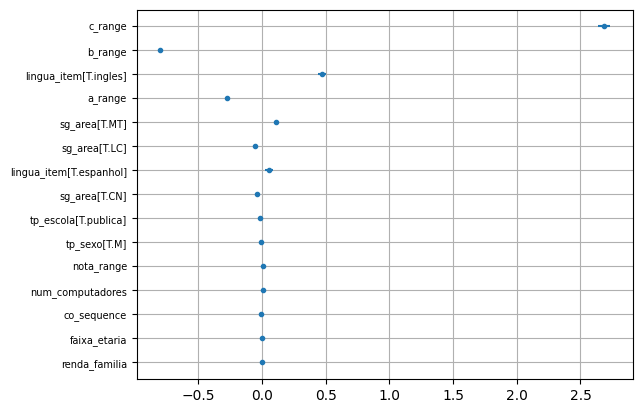

In [64]:
coefplot(result, 0.05)

## Normalized analysis

In [67]:
endog = df.acerto_freq
weights = df.weights
exog = df[[
    'co_sequence',
    'num_pessoas_residencia',
    'renda_familia',
    'faixa_etaria',
    'num_celulares',
    'num_computadores',
    'tem_internet_em_casa',
    'a_range',
    'b_range',
    'c_range',
    'nota_range',
]]
exog = sp.stats.zscore(exog)
exog = add_constant(exog)

model = sm.GLM(endog, exog, family=sm.families.Binomial(), freq_weights=weights)
result = model.fit()

In [68]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            acerto_freq   No. Observations:              1590778
Model:                            GLM   Df Residuals:                  1592173
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0057e+05
Date:                Wed, 17 Apr 2024   Deviance:                   1.8003e+06
Time:                        22:57:52   Pearson chi2:                 1.83e+06
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1660
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.6842      0.002   -364.728      0.000      -0.688      -0.681
co_sequence               -0.0649      0.002    -35.932      0.000      -0.068      -0.061
num_pessoas_residencia    -0.0018      0.002     -0.937      0.349      -0.006       0.002
renda_familia              0.0112      0.002      4.940      0.000       0.007       0.016
faixa_etaria               0.0108      0.002      5.793      0.000       0.007       0.015
num_celulares             -0.0033      0.002     -1.472      0.141      -0.008       0.001
num_computadores           0.0065      0.002      2.749      0.006       0.002       0.011
tem_internet_em_casa      -0.0014      0.002     -0.687      0.492      -0.005       0.003
a_range                   -0.2607      0.002   -126.543      0.000      -0.265      -0.257
b_range                   -0.7995      0.002   -370.408      0.000      -0.804      -0.795
c_range                    0.2120      0.002    112.008      0.000       0.208       0.216
nota_range                 0.6728      0.002    318.833      0.000       0.669       0.677
==========================================================================================
"""

,coef,pvalue,stderr,low,high
co_sequence,-0.064928,9.640347e-283,0.001807,-0.068469,-0.061386
num_pessoas_residencia,-0.001849,3.485472e-01,0.001973,-0.005716,0.002017
renda_familia,0.011165,7.831530e-07,0.002260,0.006735,0.015596
faixa_etaria,0.010840,6.913058e-09,0.001871,0.007172,0.014507
num_celulares,-0.003294,1.410520e-01,0.002238,-0.007679,0.001092
num_computadores,0.006531,5.974236e-03,0.002376,0.001875,0.011187
tem_internet_em_casa,-0.001379,4.923734e-01,0.002009,-0.005318,0.002559
a_range,-0.260736,0.000000e+00,0.002060,-0.264774,-0.256697
b_range,-0.799541,0.000000e+00,0.002159,-0.803772,-0.795310
c_range,0.212041,0.000000e+00,0.001893,0.208330,0.215751


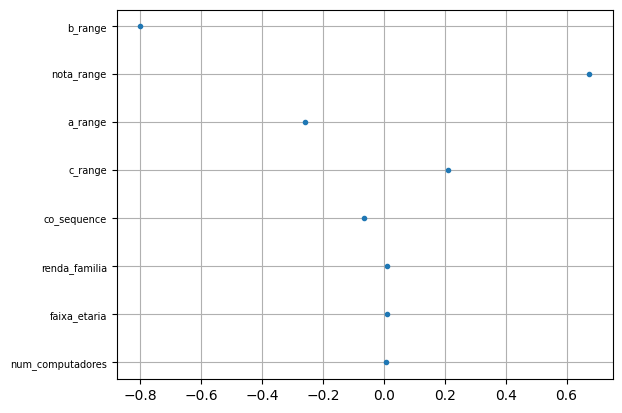

In [69]:
coefplot(result)

## With `pandas.get_dummies` to normalize

In [70]:
# Remove unnecessary variables, and some less significant categorical variables,
# to reduce memory usage.
dummy_df = df.drop(
    [
        'co_item',
        'co_posicao',
        'acerto_sum',
        'erro_sum',
        # 'educacao_pai',
        # 'educacao_mae',
        # 'tem_celular_em_casa',
        # 'tem_computador_em_casa',
        # 'tem_internet_em_casa',
        # 'tp_sexo',
        # 'tp_escola',
        # 'lingua_item',
        # 'sg_area',
    ],
    axis=1,
    errors='ignore',
)

dummy_df = pd.get_dummies(dummy_df, drop_first=True, dtype=int)

endog = dummy_df.acerto_freq
weights = dummy_df.weights
exog = dummy_df.drop(['acerto_freq', 'weights'], axis=1)
exog = sp.stats.zscore(exog)
exog = add_constant(exog)

model = sm.GLM(endog, exog, family=sm.families.Binomial(), freq_weights=weights)
result = model.fit()

In [71]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            acerto_freq   No. Observations:              1590778
Model:                            GLM   Df Residuals:                  1592151
Model Family:                Binomial   Df Model:                           33
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.9960e+05
Date:                Wed, 17 Apr 2024   Deviance:                   1.7983e+06
Time:                        22:58:20   Pearson chi2:                 1.82e+06
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1670
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.6823      0.002   -363.509      0.000      -0.686      -0.679
co_sequence               -0.0508      0.002    -26.873      0.000      -0.055      -0.047
num_pessoas_residencia    -0.0020      0.002     -0.989      0.323      -0.006       0.002
renda_familia              0.0103      0.002      4.159      0.000       0.005       0.015
tem_internet_em_casa      -0.0010      0.002     -0.500      0.617      -0.005       0.003
a_range                   -0.2685      0.002   -126.774      0.000      -0.273      -0.264
b_range                   -0.8210      0.003   -317.288      0.000      -0.826      -0.816
c_range                    0.2031      0.002    105.068      0.000       0.199       0.207
nota_range                 0.6585      0.002    298.948      0.000       0.654       0.663
faixa_etaria               0.0114      0.002      5.432      0.000       0.007       0.015
num_computadores           0.0058      0.002      2.341      0.019       0.001       0.011
num_celulares             -0.0027      0.002     -1.204      0.229      -0.007       0.002
sg_area_CN                -0.0179      0.002     -7.766      0.000      -0.022      -0.013
sg_area_LC                -0.0256      0.002    -11.474      0.000      -0.030      -0.021
sg_area_MT                 0.0492      0.003     19.327      0.000       0.044       0.054
tp_sexo_M                 -0.0046      0.002     -2.508      0.012      -0.008      -0.001
tp_escola_privada         -0.0025      0.002     -1.308      0.191      -0.006       0.001
tp_escola_publica         -0.0084      0.002     -4.204      0.000      -0.012      -0.004
lingua_item_espanhol       0.0058      0.002      3.222      0.001       0.002       0.009
lingua_item_ingles         0.0603      0.002     32.605      0.000       0.057       0.064
educacao_pai_B             0.0015      0.004      0.365      0.715      -0.007       0.010
educacao_pai_C             0.0011      0.004      0.275      0.783      -0.007       0.009
educacao_pai_D            -0.0001      0.004     -0.037      0.971      -0.008       0.008
educacao_pai_E             0.0002      0.006      0.045      0.964      -0.011       0.011
educacao_pai_F             0.0053      0.004      1.305      0.192      -0.003       0.013
educacao_pai_G             0.0019      0.004      0.487      0.626      -0.006       0.009
educacao_pai_H            -0.0019      0.004     -0.505      0.613      -0.009       0.005
educacao_mae_B            -0.0009      0.005     -0.208      0.835      -0.010       0.008
educacao_mae_C         -9.909e-05      0.005     -0.022      0.983      -0.009       0.009
educacao_mae_D             0.0022      0.005      0.445      0.657      -0.007       0.012
educacao_mae_E             0.0032      0.007      0.439      0.660      -0.011  

,coef,pvalue,stderr,low,high
co_sequence,-0.050810,4.577300e-159,0.001891,-0.054515,-0.047104
num_pessoas_residencia,-0.001967,3.228061e-01,0.001989,-0.005866,0.001932
renda_familia,0.010300,3.198464e-05,0.002477,0.005446,0.015154
tem_internet_em_casa,-0.001015,6.172735e-01,0.002030,-0.004994,0.002965
a_range,-0.268490,0.000000e+00,0.002118,-0.272641,-0.264339
b_range,-0.821005,0.000000e+00,0.002588,-0.826077,-0.815933
c_range,0.203110,0.000000e+00,0.001933,0.199321,0.206899
nota_range,0.658492,0.000000e+00,0.002203,0.654174,0.662809
faixa_etaria,0.011352,5.567221e-08,0.002090,0.007256,0.015448
num_computadores,0.005797,1.925523e-02,0.002477,0.000942,0.010651


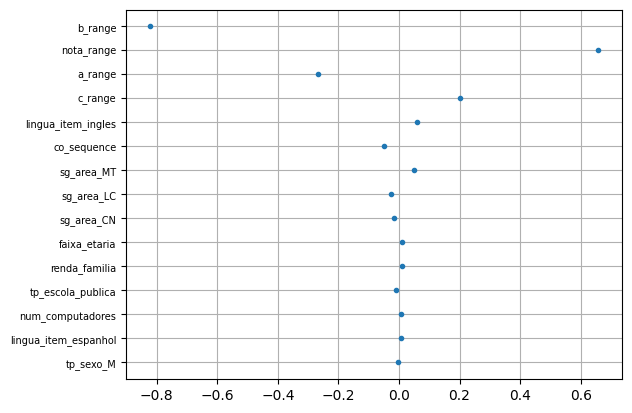

In [72]:
coefplot(result, 0.05)

# Simplified analysis

In [37]:
group_by = dict(GROUP_BY)
del group_by['educacao_pai']
del group_by['educacao_mae']
del group_by['tem_celular_em_casa']
del group_by['tem_internet_em_casa']
del group_by['num_pessoas_residencia']

sql = QUERY(sampling=0.04, co_items=co_items, group_by=group_by)
df = enem.query(sql, fetch_strategy='gcs')

df = prepare_dataset(df)

Read from cache 78c4daf8


In [38]:
df.nunique()

co_item                   178
co_posicao                180
co_sequence                45
sg_area                     4
tp_sexo                     2
tp_escola                   3
lingua_item                 3
educacao_pai                0
educacao_mae                0
num_pessoas_residencia      0
renda_familia              17
tem_internet_em_casa        0
a_range                    44
b_range                    42
c_range                    31
nota_range                 72
acerto_sum                 54
erro_sum                   91
weights                    89
acerto_freq               936
faixa_etaria               20
num_computadores            5
num_celulares               0
dtype: int64

In [39]:
df.count()

co_item                   9390644
co_posicao                9390644
co_sequence               9390644
sg_area                   9390644
tp_sexo                   9390644
tp_escola                 9390644
lingua_item               9390644
educacao_pai                    0
educacao_mae                    0
num_pessoas_residencia          0
renda_familia             9390644
tem_internet_em_casa            0
a_range                   9390644
b_range                   9390644
c_range                   9390644
nota_range                9390644
acerto_sum                9390644
erro_sum                  9390644
weights                   9390644
acerto_freq               9390644
faixa_etaria              9390644
num_computadores          9390644
num_celulares                   0
dtype: int64

In [ ]:
# Coefficients from normalized formula.
formula = normalize_formula(
    """
    acerto_freq ~
        b_range         # -0.8210
        + nota_range    # +0.6585
        + a_range       # -0.2685
        + c_range       # +0.2031
        + lingua_item   # +0.0603 [ingles]
        + co_sequence   # -0.0508
        + sg_area       # +0.0492 [MT]
        + faixa_etaria  # +0.0114
        + renda_familia          # +0.0103
        # + tp_escola              # -0.0084 [publica]
        # + num_computadores       # +0.0058
        # + educacao_pai           # +0.0053 [F]
        # + educacao_mae           # +0.0052 [G]
        # + tp_sexo                # -0.0046 [M]
        # + num_celulares          # -0.0027
        # + num_pessoas_residencia # -0.0020
        # + tem_internet_em_casa   # -0.0010
    """
)

model = smf.glm(
    formula, data=df, family=sm.families.Binomial(), freq_weights=df.weights
)
result = model.fit()

In [ ]:
result.summary()

In [ ]:
coefplot(result)

## Comparação com análise inicial

In [33]:
result_simple = result

In [42]:
result_initial = result2

In [51]:
coef_df_simple = build_coef_df(result_simple)
coef_df_initial = build_coef_df(result_initial)

In [52]:
coef_df_compare = coef_df_simple.join(coef_df_initial, how="inner", lsuffix="_simple", rsuffix="_initial")

In [56]:
coef_df_compare[['coef_simple', 'coef_initial', 'stderr_simple', 'stderr_initial']]

coef_simple  coef_initial  stderr_simple  \
lingua_item[T.espanhol]     0.035994      0.052465   4.921581e-03   
lingua_item[T.ingles]       0.474656      0.471335   4.338647e-03   
sg_area[T.CN]              -0.041226     -0.042074   1.630671e-03   
sg_area[T.LC]              -0.057829     -0.058314   1.531391e-03   
sg_area[T.MT]               0.116520      0.113821   1.774161e-03   
b_range                    -0.799283     -0.799816   7.598427e-04   
nota_range                  0.007367      0.007361   7.147176e-06   
a_range                    -0.271430     -0.271350   6.452856e-04   
c_range                     2.667642      2.683957   7.696026e-03   
co_sequence                -0.003845     -0.003921   4.396106e-05   
faixa_etaria                0.002086      0.001876   9.019532e-05   
renda_familia               0.000003      0.000002   1.223696e-07   

                         stderr_initial  
lingua_item[T.espanhol]    1.628172e-02  
lingua_item[T.ingles]      1.445579e-02  
sg_area[T.CN]              5.417660e-03  
sg_area[T.LC]              5.082368e-03  
sg_area[T.MT]              5.889366e-03  
b_range                    2.520791e-03  
nota_range                 2.462177e-05  
a_range                    2.140428e-03  
c_range                    2.554504e-02  
co_sequence                1.458929e-04  
faixa_etaria               3.452946e-04  
renda_familia              5.395351e-07

In [55]:
x1 = coef_df_compare.coef_simple
x2 = coef_df_compare.coef_initial
s1 = coef_df_compare.stderr_simple
s2 = coef_df_compare.stderr_initial

# Welch t-statistic
t = (x1 - x2)/np.sqrt(s1**2 + s2**2)
t

lingua_item[T.espanhol]   -0.968335
lingua_item[T.ingles]      0.220054
sg_area[T.CN]              0.149934
sg_area[T.LC]              0.091463
sg_area[T.MT]              0.438658
b_range                    0.202413
nota_range                 0.239224
a_range                   -0.035881
c_range                   -0.611525
co_sequence                0.494219
faixa_etaria               0.589575
renda_familia              2.068583
dtype: float64

In [57]:
n1 = 1590778
n2 = 9390644
dof = (s1**2 + s2**2)**2 / ( (s1**4)/n1 + (s2**4)/n2 )
dof

lingua_item[T.espanhol]    1.065976e+07
lingua_item[T.ingles]      1.064858e+07
sg_area[T.CN]              1.065308e+07
sg_area[T.LC]              1.065476e+07
sg_area[T.MT]              1.065441e+07
b_range                    1.065536e+07
nota_range                 1.059576e+07
a_range                    1.065559e+07
c_range                    1.065454e+07
co_sequence                1.065481e+07
faixa_etaria               1.042922e+07
renda_familia              1.022194e+07
dtype: float64

In [59]:
2*(1 - sp.stats.t.cdf(abs(t), dof))

array([0.33287724, 0.82582885, 0.88081638, 0.92712471, 0.66090909,
       0.83959374, 0.81093208, 0.97137732, 0.5408519 , 0.62115153,
       0.55547596, 0.03858523])

In [62]:
compare = pd.DataFrame(coef_df_compare[['coef_simple', 'coef_initial', 'stderr_simple', 'stderr_initial']])
compare['t-stat'] = t
compare['dof'] = dof
compare['p-value'] = 2*(1 - sp.stats.t.cdf(abs(t), dof))

In [63]:
compare

coef_simple  coef_initial  stderr_simple  \
lingua_item[T.espanhol]     0.035994      0.052465   4.921581e-03   
lingua_item[T.ingles]       0.474656      0.471335   4.338647e-03   
sg_area[T.CN]              -0.041226     -0.042074   1.630671e-03   
sg_area[T.LC]              -0.057829     -0.058314   1.531391e-03   
sg_area[T.MT]               0.116520      0.113821   1.774161e-03   
b_range                    -0.799283     -0.799816   7.598427e-04   
nota_range                  0.007367      0.007361   7.147176e-06   
a_range                    -0.271430     -0.271350   6.452856e-04   
c_range                     2.667642      2.683957   7.696026e-03   
co_sequence                -0.003845     -0.003921   4.396106e-05   
faixa_etaria                0.002086      0.001876   9.019532e-05   
renda_familia               0.000003      0.000002   1.223696e-07   

                         stderr_initial    t-stat           dof   p-value  
lingua_item[T.espanhol]    1.628172e-02 -0.968335  1.065976e+07  0.332877  
lingua_item[T.ingles]      1.445579e-02  0.220054  1.064858e+07  0.825829  
sg_area[T.CN]              5.417660e-03  0.149934  1.065308e+07  0.880816  
sg_area[T.LC]              5.082368e-03  0.091463  1.065476e+07  0.927125  
sg_area[T.MT]              5.889366e-03  0.438658  1.065441e+07  0.660909  
b_range                    2.520791e-03  0.202413  1.065536e+07  0.839594  
nota_range                 2.462177e-05  0.239224  1.059576e+07  0.810932  
a_range                    2.140428e-03 -0.035881  1.065559e+07  0.971377  
c_range                    2.554504e-02 -0.611525  1.065454e+07  0.540852  
co_sequence                1.458929e-04  0.494219  1.065481e+07  0.621152  
faixa_etaria               3.452946e-04  0.589575  1.042922e+07  0.555476  
renda_familia              5.395351e-07  2.068583  1.022194e+07  0.038585

In [65]:
compare[['coef_initial', 'coef_simple', 'p-value']]

coef_initial  coef_simple   p-value
lingua_item[T.espanhol]      0.052465     0.035994  0.332877
lingua_item[T.ingles]        0.471335     0.474656  0.825829
sg_area[T.CN]               -0.042074    -0.041226  0.880816
sg_area[T.LC]               -0.058314    -0.057829  0.927125
sg_area[T.MT]                0.113821     0.116520  0.660909
b_range                     -0.799816    -0.799283  0.839594
nota_range                   0.007361     0.007367  0.810932
a_range                     -0.271350    -0.271430  0.971377
c_range                      2.683957     2.667642  0.540852
co_sequence                 -0.003921    -0.003845  0.621152
faixa_etaria                 0.001876     0.002086  0.555476
renda_familia                0.000002     0.000003  0.038585